Import the libraries necessary to analize data

In [1261]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [1262]:
df = pd.read_csv('../df_after_dp.csv', parse_dates=['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              197914 non-null  datetime64[ns]
 1   state                             197914 non-null  object        
 2   city_or_county                    197914 non-null  object        
 3   latitude                          197914 non-null  float64       
 4   longitude                         197914 non-null  float64       
 5   congressional_district            197914 non-null  int64         
 6   avg_age_participants              197914 non-null  float64       
 7   n_participants_child              197914 non-null  int64         
 8   n_participants_teen               197914 non-null  int64         
 9   n_participants_adult              197914 non-null  int64         
 10  n_males                         

In [1263]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)

Since we use distance metric working on numerical features we remove the categorical data and useless features 

In [1264]:
column_to_drop = ['n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'age_entropy_per_state',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'total_votes_for_state', 'involve_killing']
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)

In [1265]:
numeric_attributes = [item for item in df.columns if item not in column_to_drop]
numeric_attributes

['avg_age_participants',
 'povertyPercentage',
 'males_percentage_per_city',
 'females_percentage_per_city',
 'killed_percentage_per_district',
 'injured_percentage_per_district',
 'arrested_percentage_per_district',
 'unharmed_percentage_per_district',
 'killed_percentage_per_incident',
 'winning_party_percentage',
 'unharmed_percentage',
 'arrest_percentage',
 'killed_rate_per_state',
 'injured_rate_per_state',
 'arrested_rate_per_state',
 'unharmed_rate_per_state']

<Axes: >

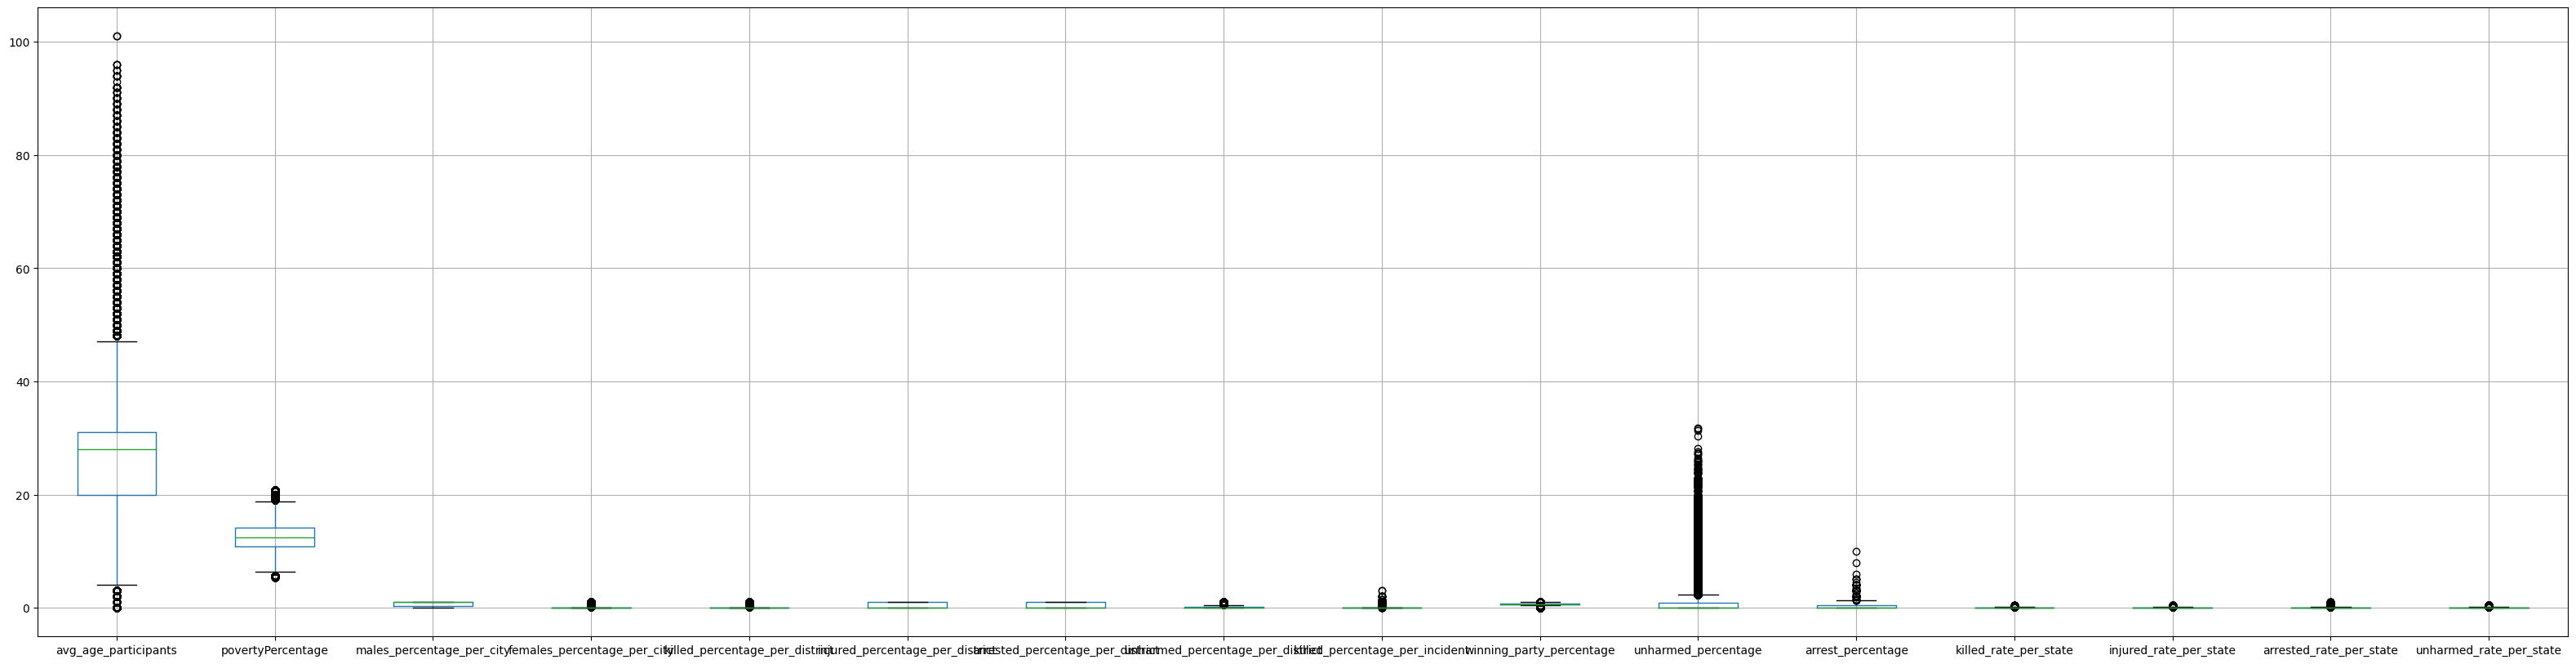

In [1266]:
df[numeric_attributes].boxplot(figsize=(40,10))

In [1267]:
attr_to_log = ['avg_age_participants', 'unharmed_percentage', 'povertyPercentage','n_participants','n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed']
df[attr_to_log] = np.log(df[attr_to_log].values)
df[attr_to_log] = df[attr_to_log].replace(-np.inf, 0)
df[attr_to_log] = df[attr_to_log].fillna(value=0)

C:\Users\mitol\AppData\Local\Temp\ipykernel_14372\166218453.py:4: RuntimeWarning: divide by zero encountered in log
  df[attr_to_log] = np.log(df[attr_to_log].values)


In [1268]:
df[numeric_attributes].describe()

,avg_age_participants,povertyPercentage,males_percentage_per_city,females_percentage_per_city,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_percentage_per_incident,winning_party_percentage,unharmed_percentage,arrest_percentage,killed_rate_per_state,injured_rate_per_state,arrested_rate_per_state,unharmed_rate_per_state
count,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000,197914.000000
mean,2.969165,2.511989,0.699127,0.155689,0.214553,0.326844,0.297665,0.226558,0.164287,0.681462,0.292570,0.254175,0.046745,0.050167,0.045157,0.048941
std,1.101617,0.213334,0.403320,0.358140,0.399548,0.437864,0.441046,0.404737,0.328837,0.130646,0.603263,0.394619,0.048984,0.049477,0.059325,0.056206
min,0.000000,1.686399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.346871,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.995732,2.379546,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.596987,0.000000,0.000000,0.000000,0.015385,0.010309,0.000000
50%,3.332205,2.517696,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.667020,0.000000,0.000000,0.034483,0.037037,0.030303,0.032258
75%,3.433987,2.646175,1.000000,0.000000,0.000000,1.000000,1.000000,0.200000,0.000000,0.749687,0.000000,0.500000,0.071429,0.070588,0.061856,0.074074
max,4.615121,3.034953,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.457893,10.000000,0.428571,0.500000,1.000000,0.480000


In [1269]:
df_numeric = df.drop(columns=column_to_drop)
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197914 entries, 0 to 197913
Data columns (total 16 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   avg_age_participants              197914 non-null  float64
 1   povertyPercentage                 197914 non-null  float64
 2   males_percentage_per_city         197914 non-null  float64
 3   females_percentage_per_city       197914 non-null  float64
 4   killed_percentage_per_district    197914 non-null  float64
 5   injured_percentage_per_district   197914 non-null  float64
 6   arrested_percentage_per_district  197914 non-null  float64
 7   unharmed_percentage_per_district  197914 non-null  float64
 8   killed_percentage_per_incident    197914 non-null  float64
 9   winning_party_percentage          197914 non-null  float64
 10  unharmed_percentage               197914 non-null  float64
 11  arrest_percentage                 197914 non-null  f

## Normalization

A good practice is to scale data to avoid that some features dominates the others in the clustering, so we done it

In [1270]:
scaler = StandardScaler()
X = scaler.fit_transform(df_numeric.values)
scaled_df = pd.DataFrame(X, columns=df_numeric.columns)

In [1271]:
scaled_df.tail()

,avg_age_participants,povertyPercentage,males_percentage_per_city,females_percentage_per_city,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_percentage_per_incident,winning_party_percentage,unharmed_percentage,arrest_percentage,killed_rate_per_state,injured_rate_per_state,arrested_rate_per_state,unharmed_rate_per_state
197909,0.296539,-0.367387,0.745993,-0.434716,-0.536989,-0.746453,1.592434,-0.559767,-0.499600,0.557295,-0.484981,1.889989,1.804456,0.540771,4.749579,1.600340
197910,0.478700,-0.534815,0.745993,2.357493,-0.536989,-0.746453,1.592434,1.910979,-0.499600,-0.329065,2.321132,1.810798,-0.954289,-0.495716,4.952867,0.676367
197911,0.024117,-0.205733,0.745993,2.357493,-0.536989,-0.746453,1.592434,-0.559767,-0.499600,0.915927,-0.484981,1.889989,0.901594,-0.653040,5.339246,-0.870751
197912,0.024117,0.175574,0.745993,2.357493,1.965842,1.537367,1.592434,-0.559767,0.977471,-0.468637,-0.484981,-0.571702,7.794873,5.944098,-0.179921,1.106122
197913,0.262280,-1.076281,0.745993,2.357493,-0.536989,-0.746453,1.592434,-0.559767,-0.499600,1.046694,-0.484981,1.889989,-0.954289,-1.013960,7.733403,-0.870751


## Saving the normalized dataset

In [1272]:
scaled_df[column_to_drop] = df[column_to_drop]

In [1273]:
scaled_df.to_csv('df_scaled.csv', index=False)

## PCA

In [1274]:
pca = PCA(n_components=2)

In [1275]:
scaled_df[['pc1','pc2']] = pca.fit_transform(scaled_df[numeric_attributes])

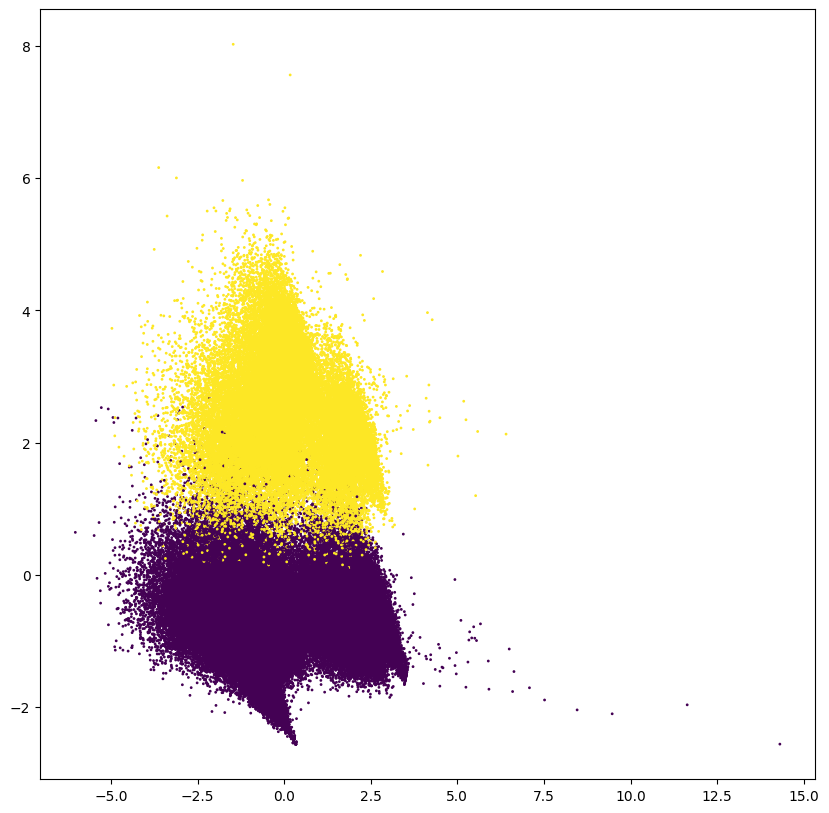

In [1276]:
plt.figure(figsize=(10,10))
plt.scatter(scaled_df['pc1'], scaled_df['pc2'],  c=scaled_df['involve_killing'], s=1) #c=scaled_df['party'].replace(dict(zip(scaled_df['party'].unique(), range(len(scaled_df['party'].unique())))))
# get the handles and labels of the legend
#handles, labels = plt.gca().get_legend_handles_labels()

# create a new legend with the state names and colors
#plt.legend(handles, scaled_df['state'].unique())

# display the plot
plt.show()

In [1277]:
""" color_scale = [(0, 'yellow'), (0.02, 'orange'), (0.15,'red'), (1, 'purple')]
fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="state", 
                        hover_data=["city_or_county", "incident_characteristics1"],
                        color="n_killed",
                        color_continuous_scale=color_scale,
                        size="n_participants",
                        zoom=3, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show() """

' color_scale = [(0, \'yellow\'), (0.02, \'orange\'), (0.15,\'red\'), (1, \'purple\')]\nfig = px.scatter_mapbox(df, \n                        lat="latitude", \n                        lon="longitude", \n                        hover_name="state", \n                        hover_data=["city_or_county", "incident_characteristics1"],\n                        color="n_killed",\n                        color_continuous_scale=color_scale,\n                        size="n_participants",\n                        zoom=3, \n                        height=800,\n                        width=800)\n\nfig.update_layout(mapbox_style="open-street-map")\nfig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})\nfig.show() '